# Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

# Function to transform the data

In [2]:
# Function to transfer from dBW to W (power)
def db2pow(db):
    return 10**(db/10)

# Function to transfer from W to dBW (power)
def pow2db(pow):
    return 10*np.log10(pow)

# Hermitian transpose of a matrix
def HermTranspose(x):
    return x.conj().T

def chanGen(zeta, d, dim1, dim2):
    """Function to generate Rayleigh fading channel coefficients

    Args:
        zeta: ξ is the path loss exponent
        d: the distance between the transmitter and the receiver
        dim1: the number of rows in the channel matrix
        dim2: the number of columns in the channel matrix
    """
    pl_ref = -30                                    # pathloss (dBW) at reference distance
    pl = db2pow(pl_ref - 10*zeta*np.log10(d))       # pathloss model at distance d
    y = np.sqrt(0.5*pl)*(np.random.randn(dim1,dim2)\
        + 1j*np.random.randn(dim1,dim2))            # Rayleigh distribution
    return y

In [3]:
def generate_random_beamforming_vectors():
    # Generate random complex numbers for each element of the beamforming vectors
    realPart = np.random.randn(number_of_users, N)
    imagPart = np.random.randn(number_of_users, N)
    beamforming_vectors = realPart + 1j * imagPart
    
    # Normalize the vectors
    beamforming_vectors = beamforming_vectors / np.linalg.norm(beamforming_vectors, axis=1, keepdims=True)
    return beamforming_vectors

def generate_random_theta():
    realPart = np.random.randn(number_of_users, Nris)
    imagPart = np.random.randn(number_of_users, Nris)
    theta = realPart + 1j * imagPart
    theta = np.exp(1j * np.angle(theta))  # Normalize theta to the unit circle
    return theta

def generateChannel():
    normFact = 1/np.sqrt(sigma)
    Hai = chanGen(zetaAI, dAI, Nris, N)                                                         # Alice to RIS channel
    hib = [normFact*chanGen(zetaIB, dIB[i], 1, Nris) for i in range(number_of_users)]           # Channel between the RIS and the legitimate receivers
    hie = [normFact*chanGen(zetaIE, dIE[i], 1, Nris) for i in range(number_of_eavesdroppers)]   # Channel between the RIS and the eavesdroppers
    hab = [normFact*chanGen(zetaAB, dAB[i], 1, N) for i in range(number_of_users)]              # Channel between Alice and the legitimate receivers
    hae = [normFact*chanGen(zetaAE, dAE[i], 1, N) for i in range(number_of_eavesdroppers)]      # Channel between Alice and the eavesdroppers
    return Hai, hib, hie, hab, hae


# Objective Function

In [4]:
def secrecy_rate_objective_function(theta, w):
    secrecy_rate = []
    for k in range(number_of_users):
        R_bk = []
        # Legitimate user k
        numGamma_bk = np.abs(np.dot(hib[k] @ np.diag(theta[k]) @ Hai + hab[k], w[k]))**2
        denGamma_bk = 1 + np.sum([np.abs(np.dot(hib[k] @ np.diag(theta[k]) @ Hai + hab[k], w[i]))**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        C_bk = np.log2(1 + gamma_bk)
        
        for i in range(number_of_eavesdroppers):
            # Eavesdropper i
            numGamma_ei = np.abs(np.dot(hie[i] @ np.diag(theta[k]) @ Hai + hae[i], w[k]))**2
            denGamma_ei = 1 + np.sum([np.abs(np.dot(hie[i] @ np.diag(theta[k]) @ Hai + hae[i], w[j]))**2 for j in range(number_of_users) if j != k])
            gamma_ei = numGamma_ei/denGamma_ei
            C_ei = np.log2(1 + gamma_ei)
            R_bk.append(C_bk - C_ei)
        
        secrecy_rate.append(max(min(R_bk),0))
    # print("Sum Rate:", sum(secrecy_rate))
    # print("Secrecy Rate:", secrecy_rate)
    return sum(secrecy_rate)

# System parameters

In [5]:
sigma = db2pow(-75)                                                                 # noise power
N = 8                                                                               # number of transmit antennas
Nris = 32                                                                           # number of RIS elements
number_of_users = 4                                                                 # number of users
number_of_eavesdroppers = 2                                                         # number of eavesdroppers
zetaAI = 2.2                                                                        # Path loss exponent of the channel between the Alice and the RIS
zetaIB = 2.5                                                                        # Path loss exponent of the channel between the legitimate receivers and the RIS
zetaIE = 2.5                                                                        # Path loss exponent of the channel between the eavesdroppers and the RIS
zetaAB = 3.5                                                                        # Path loss exponent of the channel between the Alice and the legitimate receivers
zetaAE = 3.5                                                                        # Path loss exponent of the channel between the Alice and the eavesdroppers

dAI = 50                                                                            # distance between Alice and the RIS
dv = 2                                                                              # Vertical distance between the Alice and the Eve and Bob
dABh = np.random.uniform(5, 10, size=number_of_users)                               # Horizontal distance between Alice and the legitimate receivers
dAEh = np.random.uniform(50, 150, size=number_of_eavesdroppers)                     # Horizontal distance between Alice and the eavesdroppers
dAB = [np.sqrt(dABh[i]**2 + dv**2) for i in range(number_of_users)]                 # Distance between Alice and the legitimate receivers
dAE = [np.sqrt(dAEh[i]**2 + dv**2) for i in range(number_of_eavesdroppers)]         # Distance between Alice and the eavesdroppers
dIB = [np.sqrt((dABh[i]-dAI)**2 + dv**2) for i in range(number_of_users)]           # Distance between the legitimate receivers and the RIS
dIE = [np.sqrt((dAEh[i]-dAI)**2 + dv**2) for i in range(number_of_eavesdroppers)]   # Distance between the eavesdroppers and the RIS


In [6]:
# Channel generation
Hai, hib, hie, hab, hae = generateChannel()

# Generate random theta and w
theta_init = generate_random_theta()
w_init = generate_random_beamforming_vectors()

print("distance between Alice and the receivers: ", dAB)
print("distance between Alice and the eavesdroppers: ", dAE)
print("Secret Rate:", secrecy_rate_objective_function(theta_init, w_init))

distance between Alice and the receivers:  [7.361982344809212, 8.831076325591656, 5.3856957830819985, 6.811883237655109]
distance between Alice and the eavesdroppers:  [64.70650526080337, 59.267614331325504]
Secret Rate: [1.13620906]


# Method

## Gradient Descent for Maximization (GD)

In [7]:
def compute_gradient_w(theta, w):
    grad_w = np.zeros_like(w, dtype=complex)
    
    for k in range (number_of_users):
        Z_k = hib[k] @ np.diag(theta[k]) @ Hai + hab[k]
        numGamma_bk = np.abs(np.dot(Z_k, w[k]))**2
        denGamma_bk = 1 + np.sum([np.abs(np.dot(Z_k, w[i]))**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        
        grad_gamma_bk = (HermTranspose(Z_k) @ Z_k @ w[k] + HermTranspose(HermTranspose(Z_k) @ Z_k @ w[k])) / denGamma_bk 
        grad_Cbk = (grad_gamma_bk / np.log(2)) / (1 + gamma_bk)
        
        gamma_e = []
        for i in range (number_of_eavesdroppers):
            Z_i = hie[i] @ np.diag(theta[k]) @ Hai + hae[i]
            numGamma_ei = np.abs(np.dot(Z_i, w[k]))**2
            denGamma_ei = 1 + np.sum([np.abs(np.dot(Z_i, w[j]))**2 for j in range(number_of_users) if j != k])
            gamma_ei = numGamma_ei/denGamma_ei
            gamma_e.append(gamma_ei)
        
        index_eve_max = gamma_e.index(max(gamma_e))     # Find the eavesdropper with the highest channel gain 
        Z_e_max = hie[index_eve_max] @ np.diag(theta[k]) @ Hai + hae[index_eve_max]
        numGamma_e_max = np.abs(np.dot(Z_e_max, w[k]))**2
        denGamma_e_max = 1 + np.sum([np.abs(np.dot(Z_e_max, w[l]))**2 for l in range(number_of_users) if l != k])
        gamma_e_max = numGamma_e_max/denGamma_e_max
        
        grad_gamma_e_max = (HermTranspose(Z_e_max) @ Z_e_max @ w[k] + HermTranspose(HermTranspose(Z_e_max) @ Z_e_max @ w[k])) / denGamma_e_max
        grad_Ce_max = (grad_gamma_e_max / np.log(2)) / (1 + gamma_e_max)
        
        grad_w[k] += -(grad_Cbk - grad_Ce_max)

            
        for j in range (number_of_users):
            if (j != k):
                numGamma_wj_Cbk = -numGamma_bk * (HermTranspose(Z_k) @ Z_k @ w[j] + HermTranspose(HermTranspose(Z_k) @ Z_k @ w[j]))
                denGamma_wj_Cbk = np.log(2) * (1 + gamma_bk) * denGamma_bk**2
                grad_wj_Cbk = numGamma_wj_Cbk / denGamma_wj_Cbk
                
                Z_em = hie[index_eve_max] @ np.diag(theta[k]) @ Hai + hae[index_eve_max]
                numGamma_em = np.abs(np.dot(Z_em, w[k]))**2
                denGamma_em = 1 + np.sum([np.abs(np.dot(Z_em, w[l]))**2 for l in range(number_of_users) if l != k])
                numGamma_wj_em = -numGamma_em * (HermTranspose(Z_em) @ Z_em @ w[j] + HermTranspose(HermTranspose(Z_em) @ Z_em @ w[j]))
                denGamma_wj_em = np.log(2) * denGamma_em**2 * (1 + gamma_e_max)
                
                grad_wj_em = numGamma_wj_em / denGamma_wj_em
                grad_w[j] += -(grad_wj_Cbk - grad_wj_em)
        
    return grad_w

def gradient_descent_update_w(theta, w, learning_rate):
    grad_w = compute_gradient_w(theta, w)
    w_new = w - learning_rate * grad_w
    
    # Normalize the vectors
    w_new = w_new / np.linalg.norm(w_new, axis=1, keepdims=True)
    return w_new

def gradient_descent_w(theta, initial_w, learning_rate=0.005, total_iter=100, epsilon=1e-3):
    """Main Gradient Descent Algorithm

    Args:
        theta: the phase shift matrix
        initial_w: beamforming vectors
        learning_rate: learning rate of the gradient descent algorithm. Defaults to 0.005.
        total_iter: total number of iterations. Defaults to 100.
        epsilon: the stopping criterion. Defaults to 1e-3.

    Returns:
        np.array: the optimized beamforming vectors
    """
    
    best_w = initial_w.copy()
    best_value = -secrecy_rate_objective_function(theta, best_w)
    
    current_w = initial_w.copy()
    previous_value = best_value
    
    for iteration in range(total_iter):
        current_w = gradient_descent_update_w(theta, current_w, learning_rate)
        current_value = -secrecy_rate_objective_function(theta, current_w)
        
        # print("Current Value:", current_value, "Previous Value:", previous_value)
        
        # Check for convergence
        if abs(current_value - previous_value) < epsilon:
            print("Stopped at iteration", iteration+1)
            print(epsilon, current_value[0] - previous_value[0])
            break
        
        if (current_value < best_value):
            best_w = current_w
            best_value = current_value
            
        # Update the previous value
        previous_value = current_value
        
    return best_w

def compute_gradient_theta(theta, w, epsilon=1e-3):
    grad_theta = np.zeros_like(theta, dtype=complex)
    for k in range(number_of_users):
        for i in range(Nris):
            theta_plus = theta.copy()
            theta_plus[k][i] += epsilon*1j
            theta_minus = theta.copy()
            theta_minus[k][i] -= epsilon*1j
            grad_theta[k][i] = (secrecy_rate_objective_function(theta_plus, w) - secrecy_rate_objective_function(theta_minus, w))/(2*epsilon)
            
    return grad_theta

def gradient_descent_update_theta(theta, w, learning_rate):
    grad_theta = compute_gradient_theta(theta, w)
    theta_new = theta - learning_rate * grad_theta
    
    # Normalize the vectors
    theta_new = np.exp(1j * np.angle(theta_new))  # Chuẩn hóa theta về vòng tròn đơn vị
    return theta_new

def gradient_descent_theta(initial_theta, w, learning_rate=0.005, total_iter=100, epsilon=1e-3):
    """Main Gradient Descent Algorithm

    Args:
        initial_theta: initial phase shift matrix
        w: beamforming vectors
        learning_rate: learning rate of the gradient descent algorithm. Defaults to 0.005.
        total_iter: total number of iterations. Defaults to 100.
        epsilon: the stopping criterion. Defaults to 1e-3.

    Returns:
        np.array: the optimized phase shift matrix
    """
    
    best_theta = initial_theta.copy()
    best_value = -secrecy_rate_objective_function(best_theta, w)
    
    current_theta = initial_theta.copy()
    previous_value = best_value
    
    for iteration in range(total_iter):
        current_theta = gradient_descent_update_theta(current_theta, w, learning_rate)
        current_value = -secrecy_rate_objective_function(current_theta, w)
        
        # print("Current Value:", current_value, "Previous Value:", previous_value)
        
        # Check for convergence
        if abs(current_value - previous_value) < epsilon:
            print("Stopped at iteration", iteration+1)
            print(epsilon, current_value[0] - previous_value[0])
            break
        
        if (current_value < best_value):
            best_theta = current_theta
            best_value = current_value
            
        # Update the previous value
        previous_value = current_value
        
    return best_theta

In [8]:
# Gradient Descent Algorithm
num_cycles = 500

theta_GD = theta_init.copy()
w_GD = w_init.copy()
print("Initial Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))
current_secrecy_rate = secrecy_rate_objective_function(theta_init, w_init)

GD_results = []
GD_results.append(current_secrecy_rate)

for i in range(num_cycles):
    w_opt = gradient_descent_w(theta_GD, w_GD, learning_rate=0.01, total_iter=50, epsilon=1e-3)
    theta_opt = gradient_descent_theta(theta_GD, w_GD, learning_rate=0.001, total_iter=50, epsilon=1e-3)
    theta_GD = theta_opt
    w_GD = w_opt
    
    new_secrecy_rate = secrecy_rate_objective_function(theta_opt, w_opt)
    print("Secrecy rate after cycle", i+1, ":", new_secrecy_rate)
    
    # if (new_secrecy_rate - current_secrecy_rate) < 1e-3:
    #     print("Converged")
    #     break
    
    if (i + 1) % 10 == 0:
        GD_results.append(new_secrecy_rate)
    
    current_secrecy_rate = new_secrecy_rate

Initial Secrecy Rate GD: [1.13620906]
Stopped at iteration 1
0.001 1.7723500445043783e-09
Secrecy rate after cycle 1 : [8.78316942]
Stopped at iteration 1
0.001 7.342560337519899e-09
Secrecy rate after cycle 2 : [15.16094282]
Stopped at iteration 1
0.001 9.039512249842119e-09
Secrecy rate after cycle 3 : [15.16094282]
Stopped at iteration 1
0.001 9.039512249842119e-09
Secrecy rate after cycle 4 : [15.16094282]
Stopped at iteration 1
0.001 9.039512249842119e-09
Secrecy rate after cycle 5 : [15.16094282]
Stopped at iteration 1
0.001 9.039512249842119e-09
Secrecy rate after cycle 6 : [15.16094282]
Stopped at iteration 1
0.001 9.039512249842119e-09
Secrecy rate after cycle 7 : [15.16094282]
Stopped at iteration 1
0.001 9.039512249842119e-09
Secrecy rate after cycle 8 : [15.16094282]
Stopped at iteration 1
0.001 9.039512249842119e-09
Secrecy rate after cycle 9 : [15.16094282]
Stopped at iteration 1
0.001 9.039512249842119e-09
Secrecy rate after cycle 10 : [15.16094282]
Stopped at iteration 

## Particle Swarm Optimization (PSO)

In [9]:
class Particle:
    def __init__(self):
        self.theta = theta_PSO.copy()
        self.w = w_PSO.copy()
        self.pbest_theta = self.theta.copy()
        self.pbest_w = self.w.copy()
        self.pbest_value = secrecy_rate_objective_function(self.theta, self.w)
        self.velocity_theta = generate_random_theta()
        self.velocity_w = generate_random_beamforming_vectors()

    def update_velocity_theta(self, gbest_theta, inertia =0.5, c1=1.5, c2=2.0, user_k=0):
        r1, r2 = np.random.rand(), np.random.rand()
        cognitive_velocity_theta = c1 * r1 * (self.pbest_theta[user_k] - self.theta[user_k])
        social_velocity_theta = c2 * r2 * (gbest_theta[user_k] - self.theta[user_k])
        self.velocity_theta[user_k] = inertia * self.velocity_theta[user_k] + cognitive_velocity_theta + social_velocity_theta

    def update_velocity_w(self, gbest_w, inertia = 0.5, c1=1.5, c2=2.0, user_k=0):
        r1, r2 = np.random.rand(), np.random.rand()
        cognitive_velocity_w = c1 * r1 * (self.pbest_w[user_k] - self.w[user_k])
        social_velocity_w = c2 * r2 * (gbest_w[user_k] - self.w[user_k])
        self.velocity_w[user_k] = inertia * self.velocity_w[user_k] + cognitive_velocity_w + social_velocity_w
    
    def update_position_theta(self, user_k=0):
        self.theta[user_k] += self.velocity_theta[user_k]
        self.theta[user_k] = np.exp(1j * np.angle(self.theta[user_k]))
    
    def update_position_w(self):
        self.w += self.velocity_w
        self.w = self.w / np.linalg.norm(self.w, axis=1, keepdims=True)

def PSO_optimize_theta(w, max_iter=100):
    particles = [Particle() for _ in range(number_of_users)]
    gbest_theta = particles[0].theta.copy()
    gbest_value = particles[0].pbest_value.copy()
    
    w_max = 0.9
    w_min = 0.4
    
    for iteration in range(max_iter):
        inertia = w_min + (w_max - w_min) * np.random.rand()

        for k in range(number_of_users):
            particles[k].update_velocity_theta(gbest_theta, inertia, user_k=k)
            particles[k].update_position_theta(user_k=k)
                        
            fitness_value = secrecy_rate_objective_function(particles[k].theta, w)
            
            if fitness_value > particles[k].pbest_value:
                particles[k].pbest_value = fitness_value
                particles[k].pbest_theta = particles[k].theta.copy()
            
            if fitness_value > gbest_value:
                gbest_value = fitness_value
                gbest_theta = particles[k].theta.copy()
        # print(f"Iteration {iteration+1}/{max_iter}, Global Best Value: {gbest_value}\n")
    return gbest_theta

def PSO_optimize_w(theta, max_iter=100):
    particles = [Particle() for _ in range(number_of_users)]
    gbest_w = particles[0].w.copy()
    gbest_value = particles[0].pbest_value.copy()
    
    w_max = 0.9
    w_min = 0.4
    
    for iteration in range(max_iter):
        inertia = w_min + (w_max - w_min) * np.random.rand()

        for k in range(number_of_users):
            particles[k].update_velocity_w(gbest_w, inertia, user_k=k)
            particles[k].update_position_w()
            
            fitness_value = secrecy_rate_objective_function(theta, particles[k].w)
            
            if fitness_value > particles[k].pbest_value:
                particles[k].pbest_value = fitness_value
                particles[k].pbest_w = particles[k].w.copy()
            
            if fitness_value > gbest_value:
                gbest_value = fitness_value
                gbest_w = particles[k].w.copy()
        # print(f"Iteration {iteration+1}/{max_iter}, Global Best Value: {gbest_value}\n")
    return gbest_w

def PSO_optimize_w_theta(max_iter=100):
    particles = [Particle() for _ in range(number_of_users)]
    gbest_theta = particles[0].theta.copy()
    gbest_w = particles[0].w.copy()
    gbest_value = particles[0].pbest_value.copy()
    
    w_max = 0.9
    w_min = 0.4
    
    for iteration in range(max_iter):
        inertia = w_min + (w_max - w_min) * np.random.rand()

        for k in range(number_of_users):
            particles[k].update_velocity_theta(gbest_theta, inertia, user_k=k)
            particles[k].update_position_theta(user_k=k)
            particles[k].update_velocity_w(gbest_w, inertia, user_k=k)
            particles[k].update_position_w()
            
            fitness_value = secrecy_rate_objective_function(particles[k].theta, particles[k].w)
            
            if fitness_value > particles[k].pbest_value:
                particles[k].pbest_value = fitness_value
                particles[k].pbest_theta = particles[k].theta.copy()
                particles[k].pbest_w = particles[k].w.copy()
            
            if fitness_value > gbest_value:
                gbest_value = fitness_value
                gbest_theta = particles[k].theta.copy()
                gbest_w = particles[k].w.copy()
        # print(f"Iteration {iteration+1}/{max_iter}, Global Best Value: {gbest_value}\n")
    return gbest_theta, gbest_w

In [10]:
total_iter = 100
num_cycles = 500

theta_PSO = theta_init.copy()
w_PSO = w_init.copy()

print("Initial Secrecy Rate PSO:", secrecy_rate_objective_function(theta_PSO, w_PSO))
PSO_results = []
PSO_results.append(secrecy_rate_objective_function(theta_PSO, w_PSO))

# for cycle in range(num_cycles):
#     theta_opt = PSO_optimize_theta(w_PSO, max_iter=total_iter)
#     theta_PSO = theta_opt
#     w_opt = PSO_optimize_w(theta_opt, max_iter=total_iter)
#     w_PSO = w_opt
#     print(f"Cycle {cycle+1}/{num_cycles}, Secret Rate: {secrecy_rate_objective_function(theta_opt, w_opt)}")
    
#     if (cycle + 1) % 10 == 0:
#         PSO_results.append(secrecy_rate_objective_function(theta_opt, w_opt))

for cycle in range(num_cycles):
    theta_PSO, w_PSO = PSO_optimize_w_theta(max_iter=total_iter)
    print(f"Cycle {cycle+1}/{num_cycles}, Secret Rate: {secrecy_rate_objective_function(theta_PSO, w_PSO)}")
    
    if (cycle + 1) % 10 == 0:
        PSO_results.append(secrecy_rate_objective_function(theta_PSO, w_PSO))

print(PSO_results)

Initial Secrecy Rate PSO: [1.13620906]
Cycle 1/500, Secret Rate: [3.06848282]
Cycle 2/500, Secret Rate: [4.2882186]
Cycle 3/500, Secret Rate: [4.2882186]
Cycle 4/500, Secret Rate: [4.2882186]
Cycle 5/500, Secret Rate: [4.2882186]
Cycle 6/500, Secret Rate: [4.36712915]
Cycle 7/500, Secret Rate: [4.36712915]
Cycle 8/500, Secret Rate: [4.36712915]
Cycle 9/500, Secret Rate: [4.36712915]
Cycle 10/500, Secret Rate: [4.36712915]
Cycle 11/500, Secret Rate: [4.36712915]
Cycle 12/500, Secret Rate: [6.02109895]
Cycle 13/500, Secret Rate: [6.02109895]
Cycle 14/500, Secret Rate: [6.02109895]
Cycle 15/500, Secret Rate: [6.02109895]
Cycle 16/500, Secret Rate: [6.14210681]
Cycle 17/500, Secret Rate: [6.14210681]
Cycle 18/500, Secret Rate: [6.14210681]
Cycle 19/500, Secret Rate: [6.14210681]
Cycle 20/500, Secret Rate: [6.27807801]
Cycle 21/500, Secret Rate: [6.27807801]
Cycle 22/500, Secret Rate: [6.27807801]
Cycle 23/500, Secret Rate: [6.27807801]
Cycle 24/500, Secret Rate: [6.27807801]
Cycle 25/500, 

## Genetic Algorithm (GA)

In [11]:
class Individual:
    def __init__(self):
        self.theta = theta_init.copy()
        self.w = w_init.copy() 
        
def evaluate_population(population):
    fitness = []
    for individual in population:
        theta, w = individual.theta, individual.w
        fitness.append(secrecy_rate_objective_function(theta, w))
    # print("Fitness:", fitness)
    return fitness

def select_parents(population, fitness):
    combined = list(zip(fitness, population))
    sorted_combined = sorted(combined, key=lambda x: x[0], reverse=True)
    sorted_population = [x[1] for x in sorted_combined]
    return sorted_population[:2]

def crossover(parent1, parent2):
    theta1, w1 = parent1.theta, parent1.w
    theta2, w2 = parent2.theta, parent2.w
    child_theta = (theta1 + theta2) / 2
    child_w = (w1 + w2) / 2
    new_individual = Individual()
    new_individual.theta = child_theta
    new_individual.w = child_w
    return new_individual

def mutate(individual):
    if np.random.rand() < mutation_rate:
        mutation_index = np.random.randint(len(individual.theta))
        individual.theta[mutation_index] = generate_random_theta()[mutation_index]
    if np.random.rand() < mutation_rate:
        mutation_index = np.random.randint(len(individual.w))
        individual.w[mutation_index] = generate_random_beamforming_vectors()[mutation_index]
    return individual
        
def genetic_algorithm():
    population = [Individual() for _ in range(population_size)]
    best_individual = None
    best_fitness = -np.inf
    
    for generation in range(num_generations):
        fitness = evaluate_population(population)
        current_best_fitness = max(fitness)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = population[np.argmax(fitness)]
        
        parents = select_parents(population, fitness)
        new_population = []
        for _ in range(population_size):
            parent1, parent2 = parents
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)
        
        population = new_population
        print(f"Generation {generation + 1}/{num_generations}, Best Fitness: {best_fitness}")
        
        if (generation + 1) % 10 == 0:
            GA_results.append(best_fitness)

    return best_individual

print("Initial Secrecy Rate GA:", secrecy_rate_objective_function(theta_init, w_init))

# Genetic Algorithm parameters
population_size = 30
num_generations = 10000
mutation_rate = 0.1

GA_results = []
GA_results.append(secrecy_rate_objective_function(theta_init, w_init))

Initial Secrecy Rate GA: [1.13620906]


In [12]:
# Run the genetic algorithm
best_individual = genetic_algorithm()
print("Best Individual:", best_individual.theta, best_individual.w)
print("Best Fitness:", secrecy_rate_objective_function(best_individual.theta, best_individual.w))

Generation 1/10000, Best Fitness: [1.13620906]
Generation 2/10000, Best Fitness: [2.04497468]
Generation 3/10000, Best Fitness: [2.04497468]
Generation 4/10000, Best Fitness: [2.52693464]
Generation 5/10000, Best Fitness: [2.56351241]
Generation 6/10000, Best Fitness: [2.6129076]
Generation 7/10000, Best Fitness: [2.72398757]
Generation 8/10000, Best Fitness: [2.72398757]
Generation 9/10000, Best Fitness: [2.72398757]
Generation 10/10000, Best Fitness: [2.72398757]
Generation 11/10000, Best Fitness: [2.72398757]
Generation 12/10000, Best Fitness: [2.90752659]
Generation 13/10000, Best Fitness: [2.90752659]
Generation 14/10000, Best Fitness: [2.90752659]
Generation 15/10000, Best Fitness: [2.90762331]
Generation 16/10000, Best Fitness: [2.90762331]
Generation 17/10000, Best Fitness: [4.17596669]
Generation 18/10000, Best Fitness: [4.17596669]
Generation 19/10000, Best Fitness: [4.17596669]
Generation 20/10000, Best Fitness: [4.17596669]
Generation 21/10000, Best Fitness: [4.17596669]
Ge

## Combination of PSO and GD

In [13]:
def PSO_GD(w_PSO_GD, max_iter=100):
    particles = [Particle() for _ in range (number_of_users)]
    gbest_theta = particles[0].theta.copy()
    gbest_value = particles[0].pbest_value.copy()
    w_max = 0.9
    w_min = 0.4
    
    for iteration in range(max_iter):
        inertia = w_min + (w_max - w_min) * np.random.rand()

        
        for k in range(number_of_users):
            particles[k].update_velocity_theta(gbest_theta, inertia, user_k=k)
            particles[k].update_position_theta(user_k=k)
            
            fitness_value = secrecy_rate_objective_function(particles[k].theta, particles[k].w)
            
            if fitness_value > particles[k].pbest_value:
                particles[k].pbest_theta = particles[k].theta.copy()
                particles[k].pbest_value = fitness_value
            
            if fitness_value > gbest_value:
                gbest_theta = particles[k].theta.copy()
                gbest_value = fitness_value
            
        # print(f"Iteration {iteration+1}/{total_iter}, Global Best Value: {gbest_value}\n")
    
    print("Global Best Value Before Gradient Descent: ", secrecy_rate_objective_function(gbest_theta, w_PSO_GD))
    
    gbest_w = gradient_descent_w(gbest_theta, w_PSO_GD, learning_rate=0.01, total_iter=500)
    print("Global Best Value: ", secrecy_rate_objective_function(gbest_theta, gbest_w))
    
    return gbest_theta, gbest_w

In [14]:
theta_PSO = theta_init.copy()
w_PSO = w_init.copy()

print("Initial Secrecy Rate PSO-GD:", secrecy_rate_objective_function(theta_init, w_init))

PSO_GD_results = []
PSO_GD_results.append(secrecy_rate_objective_function(theta_init, w_init))

# PSO parameters
total_iter = 100
num_cycles = 500
for i in range(num_cycles):
    theta_opt, w_opt = PSO_GD(w_PSO)
    theta_PSO, w_PSO = theta_opt, w_opt
    print("Cycle:", i+1, "Objective Function Value:", secrecy_rate_objective_function(theta_opt, w_opt))
    
    if (i + 1) % 10 == 0:
        PSO_GD_results.append(secrecy_rate_objective_function(theta_opt, w_opt))
    
    

Initial Secrecy Rate PSO-GD: [1.13620906]
Global Best Value Before Gradient Descent:  [1.13879394]
Global Best Value:  [18.7941285]
Cycle: 1 Objective Function Value: [18.7941285]
Global Best Value Before Gradient Descent:  [18.80357011]
Global Best Value:  [18.80357011]
Cycle: 2 Objective Function Value: [18.80357011]
Global Best Value Before Gradient Descent:  [18.81422035]
Global Best Value:  [18.81422035]
Cycle: 3 Objective Function Value: [18.81422035]
Global Best Value Before Gradient Descent:  [18.82488219]
Global Best Value:  [18.82488219]
Cycle: 4 Objective Function Value: [18.82488219]
Global Best Value Before Gradient Descent:  [18.83420101]
Global Best Value:  [18.83420101]
Cycle: 5 Objective Function Value: [18.83420101]
Global Best Value Before Gradient Descent:  [18.83812699]
Global Best Value:  [18.83812699]
Cycle: 6 Objective Function Value: [18.83812699]
Global Best Value Before Gradient Descent:  [18.83935098]
Global Best Value:  [18.86467853]
Cycle: 7 Objective Func

# Plot diagram

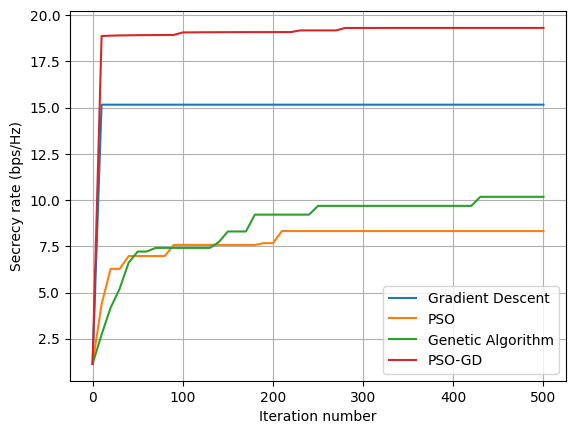

In [15]:
iterations = range(0, num_cycles+10, 10)

# Plotting the data
plt.plot(iterations, GD_results, label='Gradient Descent')
plt.plot(iterations, PSO_results, label='PSO')
plt.plot(iterations, GA_results[0:51], label='Genetic Algorithm')
plt.plot(iterations, PSO_GD_results, label='PSO-GD')

plt.xlabel('Iteration number')
plt.ylabel('Secrecy rate (bps/Hz)')
plt.grid(True)
plt.legend()
plt.show()


In [16]:
# Best results of each methods
print("Best Secrecy Rate GD:", max(GD_results))
print("Best Secrecy Rate PSO:", max(PSO_results))
print("Best Secrecy Rate GA:", max(GA_results))
print("Best Secrecy Rate PSO-GD:", max(PSO_GD_results))

Best Secrecy Rate GD: [15.16094282]
Best Secrecy Rate PSO: [8.32396581]
Best Secrecy Rate GA: [14.64089112]
Best Secrecy Rate PSO-GD: [19.31311867]
